<a href="https://colab.research.google.com/github/santteegt/om-fol-timeseries/blob/master/Federated_LSTM_model_Chest_device.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment in Colab
# !pip install syft[udacity]

In [1]:
%load_ext autoreload

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from random import randint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import syft as sy
import sys
import torch
from torch.nn import Parameter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset


hook = sy.TorchHook(torch)

# force protobuf serialization for tensors
hook.local_worker.framework = None

if(torch.cuda.is_available()):
    print('CUDA AVAILABLE')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

# IMPORTANT: Local worker should not be a client worker
# hook.local_worker.is_client_worker = False
# server = hook.local_worker

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/Users/santteegt/anaconda3/envs/pysyft-dev/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.2.so'


In [2]:
class Arguments():
    def __init__(self):
        self.batch_size = 25
        self.test_batch_size = 5
        self.epochs = 5
        self.lr = 0.02
        self.seed = 42
        self.log_interval = 1 # Log info at each batch
        self.precision_fractional = 3

args = Arguments()

torch.manual_seed(args.seed);

### Downloading data

In [ ]:
# Uncomment in Colab
# !gdown --id 1_56HAZc2XSXQCAR4iZODq9VAoyq5CvAs  # segmented dataset on my Google drive
# !ls -l

In [3]:
df = pd.read_csv('./segmented_data/all_subjects.csv', index_col=0)
df.shape

(121813, 79)

In [4]:
df.label = df.label - 1  # TODO: This should be done during data segmantation

### Creating virtual workers

In [5]:
subjects = df['subject'].unique()
subjects.sort()

workers = [sy.VirtualWorker(hook, id=subject) for subject in subjects]
crypto_provider = sy.VirtualWorker(hook, id="crypto_provider")

### Data Loader

In [ ]:
# def secret_share(tensor):
#         """
#         Transform to fixed precision and secret share a tensor.
#         Useful when performing SMPC
#         """
#         return (
#             tensor
#             .fix_precision(precision_fractional=precision_fractional)
#             .share(*workers, crypto_provider=crypto_provider, requires_grad=True)
#         )

In [ ]:
# def one_hot_of(index_tensor, classes=3):
#         """
#         Transform to one hot tensor
        
#         Example:
#             [0, 1, 2]
#             =>
#             [[1., 0., 0.],
#              [0., 1., 0.],
#              [0., 0., 1.]]
            
#         """
#         onehot_tensor = torch.zeros(*index_tensor.shape, classes)
#         onehot_tensor = onehot_tensor.scatter(1, index_tensor.view(-1, 1), 1)
#         return onehot_tensor

# # one_hot_of(torch.tensor(df['label']))

#### Exploring Strategies for train/validation data split

In [6]:
from sklearn.model_selection import StratifiedKFold, train_test_split, TimeSeriesSplit, GroupKFold

In [7]:
from matplotlib.patches import Patch

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10, xlim=[0, 100]):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=xlim)
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

(7900, 79)


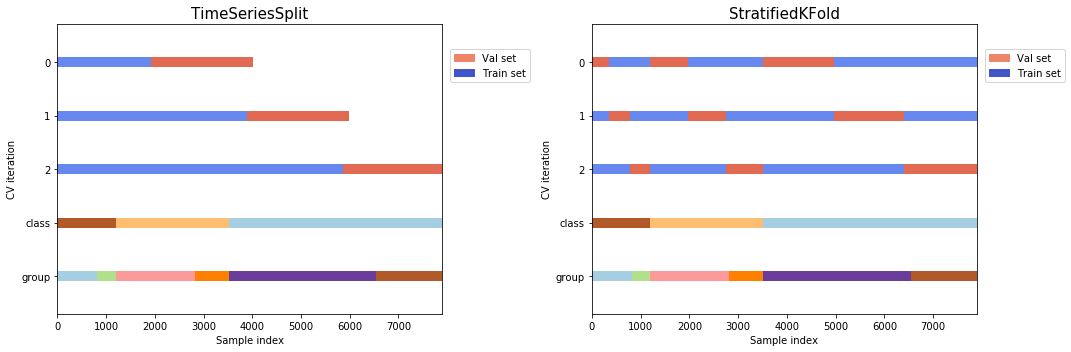

In [8]:
n_splits = 3
subject = 'S3'

data = df[df['subject'] == subject].reset_index(drop=True)
print(data.shape)
X = data.drop(columns=['subject', 'label']).copy()
y = data['label'].to_numpy()

# groups = y
subgroups = [int(perc * group) 
            for group in data[['label', 'subject']].groupby('label', sort=False).count().reset_index()['subject'].to_list() 
            for perc in [0.7, 0.3] ]
groups = np.hstack([[i] * sg for i, sg in enumerate(subgroups)])


cvs = [TimeSeriesSplit(n_splits), StratifiedKFold(n_splits, shuffle=False)]

fig, axs = plt.subplots(nrows=1, ncols=len(cvs), figsize=(15, 5))

for i, cv in enumerate(cvs):
    ax = axs[i]
    plot_cv_indices(cv, X, y, groups, ax, n_splits, xlim=[0, X.shape[0]])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Val set', 'Train set'], loc=(1.02, .8))
    # Make the legend fit
    plt.tight_layout()



In [9]:
n_splits = 3
cv = StratifiedKFold(n_splits, shuffle=False)
folds = list(cv.split(X=X, y=y, groups=groups))

random_choice = randint(0, n_splits - 1)
print('Fold to choose', random_choice)
train, val = folds[random_choice]
train.shape, val.shape

Fold to choose 2


((5267,), (2633,))

In [10]:
data.iloc[val].shape

(2633, 79)

In [ ]:
# class WESADDataset(torch.utils.data.Dataset):
#     #Constructor is mandatory
#     def __init__(self, dataframe, transform=None):
#         # normalizer = StandardScaler()
#         # Since different subjects have different responses on the signal values, min-max normalisation was conducted across different signals to normalize them to the same scale
#         normalizer = MinMaxScaler()
#         self.dataframe = dataframe.drop(columns=['subject','label'])
#         # self.X = self.dataframe.astype(np.float32).to_numpy()
#         # Normalize features
#         self.X = torch.tensor(normalizer.fit_transform(self.dataframe.astype(np.float32))).tag('#wesad', '#chest_device', '#data')
#         self.labels = torch.tensor(dataframe['label'].to_numpy()).tag('#wesad', '#chest_device', '#target')
#         self.transform = transform # e.g. torch.Tensor
    
#     # def to_torchtensor(self):            
#     #     self.dataframe = torch.from_numpy(self.dataframe)
#     #     self.labels = torch.from_numpy(self.labels)
    
#     def __len__(self):
#         #Mandatory
#         '''Returns:
#                 Length [int]: Length of Dataset/batches
#         '''
#         return self.dataframe.shape[0]

#     def __getitem__(self, idx): 
#         #Mandatory 
        
#         '''Returns:
#                     Data [Torch Tensor]: 
#                     Target [ Torch Tensor]:
#         '''
#         sample = self.X[idx]
#         # sample = self.X[idx].reshape(1, -1)
#         target = self.labels[idx]
                
#         if self.transform:
#             sample = self.transform(sample)

#         return sample, target

In [11]:
def get_data_loader(df, subject, train_batch_size=25, val_batch_size=5, random_state=42):

    normalizer = MinMaxScaler()
    data = df[df['subject'] == subject].reset_index(drop=True)

    X = data.drop(columns=['subject', 'label']).copy()
    X = normalizer.fit_transform(X.astype(np.float32))
    y = data['label'].to_numpy()

    # TODO: what's the best strategy to get train/val for each worker?
    #       Right now validation set contains data from one affect state only
    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    # # train = WESADDataset(train_data)
    # # test = WESADDataset(val_data)

    # X_train = torch.from_numpy(X_train)
    # y_train = one_hot_of(torch.from_numpy(y_train))
    # X_val = torch.from_numpy(X_val)
    # y_val = one_hot_of(torch.from_numpy(y_val))

    # train = TensorDataset(X_train, y_train)
    # test = TensorDataset(X_val, y_val)

    

    # Train/Validation split strategy
    # #########################
    n_splits = 3
    subgroups = [round(perc * group) 
                for group in data[['label', 'subject']].groupby('label', sort=False).count().reset_index()['subject'].to_list() 
                for perc in [0.7, 0.3] ]
    groups = np.hstack([[i] * sg for i, sg in enumerate(subgroups)])

    cv = StratifiedKFold(n_splits, shuffle=False)
    # print('Sizes', len(X), len(y), len(groups))
    folds = list(cv.split(X=X, y=y, groups=groups))

    random_choice = randint(0, n_splits - 1)
    print('Fold to choose', subject, random_choice)
    train_idx, val_idx = folds[random_choice]
    
    # #########################

    X_train = X[train_idx]
    X_train = torch.from_numpy(X_train)
    y_train = y[train_idx]
#     y_train = one_hot_of(torch.from_numpy(y_train))  # one-hot encoder
    y_train = nn.functional.one_hot(torch.from_numpy(y_train), 3)
    
#     X_train = X_train.fix_precision(precision_fractional=3)
#     y_train = y_train.fix_precision(precision_fractional=3)

#     train = TensorDataset(X_train, y_train)
    train_ds = sy.BaseDataset(X_train, y_train)

    valid = data.iloc[val_idx].copy()


#     train_dl = torch.utils.data.DataLoader(train, 
#                                            batch_size=train_batch_size, 
#                                            shuffle=False, 
# #                                            pin_memory=True, 
#                                            num_workers=4
#                                           )

    val_dl = torch.utils.data.DataLoader(valid, 
                                         batch_size=val_batch_size, 
                                         shuffle=False, 
#                                          pin_memory=True, 
                                         num_workers=4
                                        )
    
#     return train_dl, val_dl
    return train_ds, val_dl

In [12]:
def get_private_data_loaders(workers, crypto_provider=None, precision_fractional=None):
    train_dataloaders = []
    # private_val_loader = []
    val_dataloaders = []
    for worker in workers:
        # train_dl, val_dl = get_data_loader(df, worker.id)
        train_ds, val_dl = get_data_loader(df, worker.id)
        train_dataloaders.append(train_ds.tag('#wesad', '#chest_device', '#data').send(worker))
#         for data_, labels_ in train_dl:
#             data = data_.tag('#wesad', '#chest_device', '#data').send(worker)
#             targets = labels_.tag('#wesad', '#chest_device', '#target').send(worker)
#             train_dataloaders.append(BaseDataset(data, targets, owner=worker))
            
            
#             private_train_loaders.append((data.tag('#wesad', '#chest_device', '#data').send(worker), 
#                                          labels.tag('#wesad', '#chest_device', '#target').send(worker)))
            # private_train_loader.append((data.tag('#wesad', '#chest_device', '#data').fix_precision(precision_fractional=args.precision_fractional).send(worker), 
            #                              labels.tag('#wesad', '#chest_device', '#target').fix_precision(precision_fractional=args.precision_fractional).send(worker)))
        # for data, labels in val_dl:
        #     private_val_loader.append((data.tag('#wesad', '#chest_device', '#data').send(worker), 
        #                                labels.tag('#wesad', '#chest_device', '#target').send(worker)))
        #     # private_val_loader.append((data.tag('#wesad', '#chest_device', '#data').fix_precision(precision_fractional=args.precision_fractional).send(worker), 
        #     #                            labels.tag('#wesad', '#chest_device', '#target').fix_precision(precision_fractional=args.precision_fractional).send(worker)))
        # private_val_loader.append(val_dl)
        
        val_dataloaders.append(val_dl)
    return train_dataloaders, val_dataloaders

In [13]:
# %%time
precision_fractional = 3

private_ds, central_val_dl = get_private_data_loaders(workers=workers,
#                                                       crypto_provider=crypto_provider,
#                                                       precision_fractional=precision_fractional,
                                                     )

print(len(private_ds), len(central_val_dl))
federated_train_ds = sy.FederatedDataset(private_ds)
federated_train_dl = sy.FederatedDataLoader(federated_train_ds, shuffle=False, batch_size=args.batch_size)

Fold to choose S10 1
Fold to choose S11 0
Fold to choose S13 0
Fold to choose S14 2
Fold to choose S15 2
Fold to choose S16 2
Fold to choose S17 1
Fold to choose S2 0
Fold to choose S3 1
Fold to choose S4 1
Fold to choose S5 1
Fold to choose S6 1
Fold to choose S7 1
Fold to choose S8 1
Fold to choose S9 0
15 15


In [ ]:
# w = workers[1]
# len(list(w._objects.keys()))
# x = w._objects[list(w._objects.keys())[0]]
# print(x)
# len(w.search(['#wesad', '#chest_device', '#target']))

In [3]:
%autoreload
# from syft.frameworks.torch.nn import LSTM
# from handcrafted_RNN import LSTM
from custom_LSTM import LSTM

### Model Specification

In [4]:
class WesadLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=3, lstm_layers=1, dropout=0.2):
        # super(WesadLSTM, self).__init__(id="encrypted-model")
        super(WesadLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.classes = output_dim
        self.lstm = LSTM(input_size=input_dim, hidden_size=input_dim, num_layers=lstm_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def init_hidden(self, batch_size):
        return self.lstm.init_hidden(batch_size), self.lstm.init_hidden(batch_size)

    def forward(self, x, h):
        lstm_out, _ = self.lstm(x, h)
#         out = self.fc(lstm_out.view(-1, self.hidden_dim))
        out = self.fc(lstm_out)
#         out = F.softmax(out.view(-1, self.classes), dim=1)
#         out = F.softmax(out, dim=1)
        return out

### Asynchronous Federated learning

In [ ]:
%autoreload
import syft as sy

#### Utils

In [5]:
def set_model_params(module, params_list, start_param_idx=0):
    """
    Set params list into model recursively.
    """
    param_idx = start_param_idx

    for name, param in module._parameters.items():
        # A param can be None if it is not trainable.
        if param is not None:
            module._parameters[name] = params_list[param_idx]
            param_idx += 1

    for name, child in module._modules.items():
        if child is not None:
            param_idx = set_model_params(child, params_list, param_idx)

    return param_idx

In [6]:
def naive_sgd(param, **kwargs):
    print(param)
    print(kwargs['lr'])
    print(param.requires_grad, param.grad)
    return param - kwargs['lr'] * param.grad

#### Loss function

In [7]:
def softmax_cross_entropy_with_logits(logits, targets, batch_size):
    """ Calculates softmax entropy
        Args:
            * logits: (NxC) outputs of dense layer
            * targets: (NxC) one-hot encoded labels
            * batch_size: value of N, temporarily required because Plan cannot trace .shape
    """
    # numstable logsoftmax
    norm_logits = logits - logits.max()
    log_probs = norm_logits - norm_logits.exp().sum(dim=1, keepdim=True).log()
    # NLL, reduction = mean
    return -(targets * log_probs).sum() / batch_size

#### Hyperparameters

In [8]:
train_batch_size = 25
val_batch_size = 5
input_dim = 77
output_dim = 3
lstm_layers = 5
dropout = 0.5
lr = 1e-4

#### Training Plan definition

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(77, 392)
        self.fc2 = nn.Linear(392, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [10]:
model = WesadLSTM(input_dim=input_dim, hidden_dim=input_dim, output_dim=output_dim, lstm_layers=lstm_layers,
                  dropout=dropout)

# model = Net()

@sy.func2plan()
def training_plan(data, target, h, c, batch_size, lr, model_parameters):
    # inject params into model
    set_model_params(model, model_parameters)
    # forward pass
    logits = model(data, (h, c))
#     logits = model.forward(data)
    
#     batch_size = out.shape[0]
#     loss = ((out - target)**2).sum().refresh()/batch_size
    # loss
    loss = softmax_cross_entropy_with_logits(logits, target, batch_size)
    print('loss', loss)
    # backprop
    loss.backward()
    print('post backprop')
    
    # step
    updated_params = [
        naive_sgd(param, lr=lr)
        for param in model_parameters
    ]
    
    # accuracy
    pred = torch.argmax(logits, dim=1)
    y = torch.argmax(target, dim=1)
    acc = pred.eq(y).sum().float() / batch_size

    return (
        loss,
        acc,
        *updated_params
    )


#### Building a Plan 

In [11]:
data = torch.rand((train_batch_size, input_dim), dtype=torch.float32)

target = torch.randint(0, output_dim - 1, (train_batch_size,))
target = nn.functional.one_hot(target, output_dim)

h, c = model.init_hidden(train_batch_size)

# model_state = list(model.parameters())
model_state = [param.data for param in model.parameters()] # raw tensors instead of nn.Parameter


# Plan._build_translators = []
training_plan.build(data, target, h, c, 
                        torch.tensor([train_batch_size]), 
                        torch.tensor([lr]), 
                        model_state, 
                        trace_autograd=True)

loss AutogradTensor>PlaceHolder[Id:27806206920]>tensor([1.0940])


KeyboardInterrupt: 

In [1]:
# END - Skip cells below
FAIL-ON-PURPOSE

NameError: name 'FAIL' is not defined

### Synchronous Federated learning

In [ ]:
train_batch_size = args.batch_size
val_batch_size = args.test_batch_size
input_dim = df.drop(columns=['subject', 'label']).shape[1]
output_dim = 3
# output_dim = 1
lstm_layers = 5
dropout = 0.5
lr = 1e-4
model = WesadLSTM(input_dim=input_dim, hidden_dim=input_dim, output_dim=output_dim, lstm_layers=lstm_layers,
                  dropout=dropout)
# model.fix_precision()

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr);
# optimizer.fix_precision()

In [ ]:
EPOCHS = 10
BATCH_SIZE = train_batch_size
VAL_BATCH_SIZE = val_batch_size
HIDDEN_DIM = input_dim

log_interval = 100  # batches

for e in range(EPOCHS):
    
    ######### Training ##########
    
    losses = []
    # Batch loop
    last_worker = None
    for batch_idx, (inputs, labels) in enumerate(federated_train_dl):
        # Location of current batch
        worker = inputs.location
        if last_worker != worker.id:
            last_worker = worker.id
            print('\nfrom', last_worker, end="")
        else:
            print('.', end="")
            
        batch_size = inputs.shape[0]
            
        # Initialize hidden state and send it to worker
        hc = (torch.Tensor(np.zeros((batch_size, HIDDEN_DIM))).send(worker), torch.Tensor(np.zeros((batch_size, HIDDEN_DIM))).send(worker))
        # Send model to current worker
        model.send(worker)
        # Setting accumulated gradients to zero before backward step
        optimizer.zero_grad()
        # Output from the model
        output, _ = model(inputs, hc)
        # Calculate the loss and perform backprop
        # loss = criterion(output.squeeze(), labels.float())
        batch_size = output.shape[0]
#         print('sum', ((output - labels)**2).sum().get())
#         loss = ((output - labels)**2).sum().refresh() / batch_size
        loss = ((output - labels)**2).sum() / batch_size
        loss.backward()
        # Clipping the gradient to avoid explosion
#         nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        # Backpropagation step
        optimizer.step() 
        # Get the model back to the local worker
        model.get()
        losses.append(loss.get())
        
        if batch_idx % log_interval == 0:
            print("\nEpoch {}/{}...  \
            Batches: {} ... \
            Training loss: {:.5f}".format(e+1, EPOCHS, batch_idx, sum(losses)/len(losses)))  
            
        break
    
    ######## Evaluation ##########
    
    # Model in evaluation mode
    print('now eval')
#     model.eval()

#     with torch.no_grad():
#         test_preds = []
#         test_labels_list = []
#         eval_losses = []

#         for inputs, labels in central_val_dl:
#             # get current location
#             worker = inputs.location
            
#             # Initialize hidden state and send it to worker
#             # h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)
#             hc = (torch.Tensor(np.zeros((VAL_BATCH_SIZE, HIDDEN_DIM))), torch.Tensor(np.zeros((VAL_BATCH_SIZE, HIDDEN_DIM))))
#             # Send model to worker
#             # model.send(worker)
            
#             output, _ = model(inputs, hc)
# #             print('output_test', output.get())
# #             loss = criterion(output.squeeze(), labels.float())
#             batch_size = output.shape[0]
#             loss = ((output - labels)**2).sum() / batch_size
#             eval_losses.append(loss.get())
#             preds = output.squeeze().get()
#             test_preds += list(preds.numpy())
#             test_labels_list += list(labels.get().numpy().astype(int))
#             # Get the model back to the local worker
#             # model.get()
        
#         # score = roc_auc_score(test_labels_list, test_preds)
    
# #     print("Epoch {}/{}...  \
# #     AUC: {:.3%}...  \
# #     Training loss: {:.5f}...  \
# #     Validation loss: {:.5f}".format(e+1, EPOCHS, score, sum(losses)/len(losses), sum(eval_losses)/len(eval_losses)))
#     print("Epoch {}/{}...  \
#     Training loss: {:.5f}...  \
#     Validation loss: {:.5f}".format(e+1, EPOCHS, sum(losses)/len(losses), sum(eval_losses)/len(eval_losses)))
    
#     model.train()

### WIP (until Plan is fixed)

In [ ]:
model.train()
for data, labels in private_train_loader:
    optimizer.zero_grad()
#     set_model_params(model, list(model.parameters()))
    try_batch.build(data, labels, trace_autograd=True)
#     try_batch.build(data)
    try_batch(model, private_train_loader)
    
    optimizer.step()
    break

### Train/Test functions

In [ ]:
## For Federated learning with secure aggregation
# def update_model(data, target, model, optimizer):
#     model.send(data.location)
#     optimizer.zero_grad()
#     pred = model(data)
#     loss = F.mse_loss(pred.view(-1), target)
#     loss.backward()
#     optimizer.step()
#     return model

In [ ]:
# def train(args, model, device, federated_train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
#         model.send(data.location) # <-- NEW: send the model to the right location
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         model.get() # <-- NEW: get the model back
#         if batch_idx % args.log_interval == 0:
#             loss = loss.get() # <-- NEW: get the loss back
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
#                 100. * batch_idx / len(federated_train_loader), loss.item()))


def train(args, model, federated_train_loader, optimizer, epoch, device=None):
    model.train()
    for batch_idx, (data,target) in enumerate(federated_train_loader):
        worker = data.location
        model.send(worker)

        optimizer.zero_grad()
        # update the model
        print(data.shape)
        pred = model(data)
        loss = F.mse_loss(pred.view(-1), target)
        loss.backward()
        optimizer.step()
        model.get()
            
        if batch_idx % args.log_interval == 0:
            loss = loss.get()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * data.shape[0], len(train_loader),
                       100. * batch_idx / len(train_loader), loss.item()))
        


## Federated learning with secure aggregation
# def train(epoch):
#     for data_index in range(len(remote_dataset[0])-1):
#         # update remote models
#         for remote_index in range(len(compute_nodes)):
#             data, target = remote_dataset[remote_index][data_index]
#             models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])

#         # encrypted aggregation
#         new_params = list()
#         for param_i in range(len(params[0])):
#             spdz_params = list()
#             for remote_index in range(len(compute_nodes)):
#                 spdz_params.append(params[remote_index][param_i].fix_precision().share(bob, alice, crypto_provider=james).get())

#             new_param = (spdz_params[0] + spdz_params[1]).get().float_precision()/2
#             new_params.append(new_param)

#         # cleanup
#         with torch.no_grad():
#             for model in params:
#                 for param in model:
#                     param *= 0

#             for model in models:
#                 model.get()

#             for remote_index in range(len(compute_nodes)):
#                 for param_index in range(len(params[remote_index])):
#                     params[remote_index][param_index].set_(new_params[param_index])

## When sharing the model among all participants (SMPC)
# def train(args, model, private_train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(private_train_loader): # <-- now it is a private dataset
#         start_time = time.time()
        
#         optimizer.zero_grad()
        
#         output = model(data)
        
#         # loss = F.nll_loss(output, target)  <-- not possible here
#         batch_size = output.shape[0]
#         loss = ((output - target)**2).sum().refresh()/batch_size
        
#         loss.backward()
        
#         optimizer.step()

#         if batch_idx % args.log_interval == 0:
#             loss = loss.get().float_precision()
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.3f}s'.format(
#                 epoch, batch_idx * args.batch_size, len(private_train_loader) * args.batch_size,
#                 100. * batch_idx / len(private_train_loader), loss.item(), time.time() - start_time))
            

In [ ]:
# def test(args, model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
#             pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

def test(args, model, private_test_loader, device=None):
    model.eval()
    test_loss = 0
    total_rec = 0
    for data, target in private_test_loader:
        total_rec += len(data)
        output = model(data)
        test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        
    # test_loss /= len(test_loader.dataset)
    test_loss /= total_rec
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))


## Federated learning with secure aggregation
# def test():
#     models[0].eval()
#     test_loss = 0
#     for data, target in test_loader:
#         output = models[0](data)
#         test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item() # sum up batch loss
#         pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        
#     test_loss /= len(test_loader.dataset)
#     print('Test set: Average loss: {:.4f}\n'.format(test_loss))


## When sharing the model among all participants (SMPC)
# def test(args, model, private_test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in private_test_loader:
#             start_time = time.time()
            
#             output = model(data)
#             pred = output.argmax(dim=1)
#             correct += pred.eq(target.view_as(pred)).sum()

#     correct = correct.get().float_precision()
#     print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
#         correct.item(), len(private_test_loader)* args.test_batch_size,
#         100. * correct.item() / (len(private_test_loader) * args.test_batch_size)))

### Training

In [ ]:
## Federated learning with secure aggregation
# model = Net()
# model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)

# optimizer = optim.SGD(model.parameters(), lr=args.lr)
# optimizer = optimizer.fix_precision() 

# for epoch in range(1, args.epochs + 1):
#     train(args, model, private_train_loader, optimizer, epoch)
#     test(args, model, private_test_loader)

In [ ]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(args, model, private_train_loader, optimizer, epoch)